In [1]:
import sys; sys.version

'3.9.5 (default, Nov 23 2021, 15:27:38) \n[GCC 9.3.0]'

Preferred way to open this Jupyter notebook is:

```
conda deactivate
source ~/myenv/bin/activate
cd ~/Desktop/palau-guts-experiment
jupyter lab
```
Should be run using **python 3.9** in a kernel named **Python 3 (ipykernel)**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import lifelines # for survival analysis
import os

In [3]:
TREATMENT_DATE = '2022-12-06'

## Read beetles.csv

In [4]:
df_beetles = pd.read_csv('beetles.csv')
df_beetles

,sn,sex,treatment
0,1,M,V
1,2,M,C
2,3,M,C
3,4,M,V
4,5,M,V
...,...,...,...
222,223,F,V
223,224,F,V
224,225,F,V
225,226,F,V


In [5]:
assert(df_beetles.sn.is_unique)

## Read mortality.csv

In [6]:
df_mortality = pd.read_csv('mortality.csv', parse_dates=['date'])
df_mortality

,sn,date
0,169,2022-12-09
1,27,2022-12-09
2,124,2022-12-09
3,24,2022-12-09
4,11,2022-12-09
...,...,...
88,68,2023-01-16
89,77,2023-01-16
90,45,2023-01-16
91,74,2023-01-16


In [7]:
# assert(df_mortality.sn.is_unique)
dups = df_mortality.duplicated(subset=['sn'], keep=False)
df_dups = df_mortality[dups]
df_dups = df_dups.sort_values(['sn','date'])
df_dups

,sn,date
72,6,2023-01-04
73,6,2023-01-09
41,25,2022-12-26
85,25,2023-01-16
67,93,2023-01-04
79,93,2023-01-09
63,96,2023-01-04
78,96,2023-01-09
61,123,2023-01-04
75,123,2023-01-09


In [8]:
# Mark all duplicate records except for the last as "reject"

dups = df_mortality.duplicated(subset=['sn'], keep='last')
df_mortality['reject'] = dups
df_mortality = df_mortality[df_mortality.reject==False]
df_mortality

,sn,date,reject
0,169,2022-12-09,False
1,27,2022-12-09,False
2,124,2022-12-09,False
3,24,2022-12-09,False
4,11,2022-12-09,False
...,...,...,...
88,68,2023-01-16,False
89,77,2023-01-16,False
90,45,2023-01-16,False
91,74,2023-01-16,False


## Add days_post_treatment column

In [9]:
df_mortality['days_post_treatment'] = (df_mortality['date'] - pd.to_datetime(TREATMENT_DATE)).dt.days
df_mortality

/tmp/ipykernel_196063/1542106039.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mortality['days_post_treatment'] = (df_mortality['date'] - pd.to_datetime(TREATMENT_DATE)).dt.days


,sn,date,reject,days_post_treatment
0,169,2022-12-09,False,3
1,27,2022-12-09,False,3
2,124,2022-12-09,False,3
3,24,2022-12-09,False,3
4,11,2022-12-09,False,3
...,...,...,...,...
88,68,2023-01-16,False,41
89,77,2023-01-16,False,41
90,45,2023-01-16,False,41
91,74,2023-01-16,False,41


## Merge beetles and mortality tables

In [10]:
df = df_beetles.merge(df_mortality, how='left')
df['dead'] = df['days_post_treatment'].notna()
df['days_post_treatment'] = df.days_post_treatment.fillna(df.days_post_treatment.max())
df

,sn,sex,treatment,date,reject,days_post_treatment,dead
0,1,M,V,NaT,NaN,41.0,False
1,2,M,C,NaT,NaN,41.0,False
2,3,M,C,2022-12-21,False,15.0,True
3,4,M,V,2022-12-09,False,3.0,True
4,5,M,V,NaT,NaN,41.0,False
...,...,...,...,...,...,...,...
222,223,F,V,2022-12-13,False,7.0,True
223,224,F,V,2022-12-19,False,13.0,True
224,225,F,V,2022-12-26,False,20.0,True
225,226,F,V,2022-12-28,False,22.0,True


## Statistics

In [11]:
treated = df.treatment == 'V'
untreated = df.treatment == 'C'

stats = lifelines.statistics.logrank_test(
    durations_A = df[treated]['days_post_treatment'],
    durations_B = df[untreated]['days_post_treatment'],
    event_observed_A = df[treated]['dead'],
    event_observed_B = df[untreated]['dead'])
print(stats)

if stats.p_value < 0.05:
    stats_result = f'Difference between curves is significant (logrank test; p = {stats.p_value:.3f})'
else:
    stats_result = f'Difference between curves is not significant\n(logrank test; p = {stats.p_value:.3f})'
print(stats_result)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           7.70 0.01      7.50
Difference between curves is significant (logrank test; p = 0.006)


## Plot

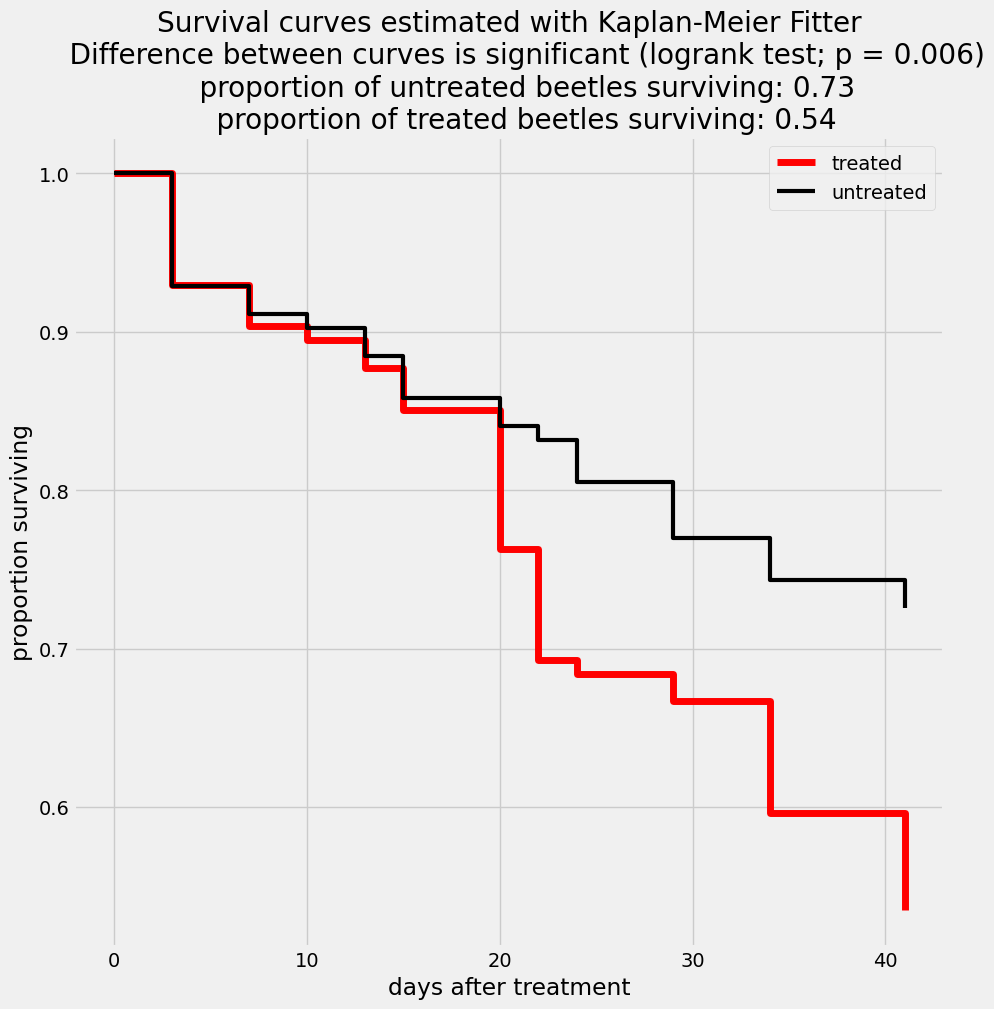

In [12]:
ax = plt.subplot()
kmf = lifelines.KaplanMeierFitter()

kmf.fit(durations=df[treated]['days_post_treatment'],
        event_observed=df[treated]['dead'], 
        label='treated')
kmf.plot(figsize=(8,8), ax=ax, ci_show=False, color='red', linewidth=5)

kmf.fit(durations=df[untreated]['days_post_treatment'], 
        event_observed=df[untreated]['dead'], 
        label='untreated')
kmf.plot(figsize=(10,10), ax=ax, ci_show=False, color='black', linewidth=3)

title = f'''Survival curves estimated with Kaplan-Meier Fitter
    {stats_result}
    proportion of untreated beetles surviving: {1 - sum(untreated & df.dead)/sum(untreated):.2f}
    proportion of treated beetles surviving: {1 - sum(treated & df.dead)/sum(treated):.2f}'''

plt.title(title)
plt.xlabel('days after treatment')
plt.ylabel('proportion surviving')
plt.savefig('results.png', bbox_inches='tight')
plt.show();

In [13]:
# Update GitHub repo

os.system('git pull')
os.system('git add .')
os.system('git commit -m "safety"')
os.system('git push')

Already up to date.
[main 217ac53] safety
 3 files changed, 1156 insertions(+), 1131 deletions(-)
 rewrite newt.ipynb (74%)
 rewrite results.png (97%)


To https://github.com/aubreymoore/palau-guts-experiment.git
   3056a98..217ac53  main -> main


0